In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pandas as pd
import os
import random
import csv
from sys import platform
from IPython.core.display import HTML
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

/Users/abir.deb/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/abir.deb/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average



def load_data(dir, lst_files_to_load, path_slash):
    '''
    LOAD DATA from dir that contains data files in csv format; path_slash contains a string used for directories
    #in a path ('/' in Unix based system or '\\' in Windows)
    '''
    files = os.listdir(dir)
    #initialize a dictionary to store csv files
    data_dict = {}
    for fil in files:
        if fil in lst_files_to_load:
            filePath = dir + path_slash + fil
            data_dict[fil[:-4]] = pd.DataFrame.from_csv(filePath)
    return data_dict



def gather_drive_data(GAME_df, DRIVE_df, year):
    '''
    This function filters and returns DRIVE_df with 'gid', 'fpid', and 'plays' which are all necessary
    to gather play by play data in later step
    '''
    columns_of_interest = ['gid', 'fpid', 'plays']
    GAME_df_filtered = GAME_df[GAME_df.seas == year]
    GAME_DRIVE_joined_df = DRIVE_df.join(GAME_df_filtered, on = 'gid', how = 'inner')
    
    return GAME_DRIVE_joined_df[columns_of_interest]



def find_plays(first_play_id, num_plays, sub_play_df):
    '''
    return a data frame with all the plays (RUN OR PASS) from a given first_play_id, num_plays and sub_play_df
    (which contains all the plays we need to filter out and return as a data frame)
    '''
    columns_of_interest = [
        'pid', 'off', 'def', 'type', 'qtr', 'min', 'sec'
        , 'ptso', 'ptsd', 'dwn', 'ytg', 'yfog', 'zone'
         , 'sg', 'nh', 'timo', 'timd'
    ]
    
    #calculate the last play's play_id
    last_play_id = first_play_id + num_plays
    
    #gather all the pass/rush plays from sub_play_df using the range of play_ids given for the drive
    all_plays_in_drive = sub_play_df[np.logical_and(np.logical_or(sub_play_df.type == 'PASS', sub_play_df.type == 'RUSH'),
                                            np.logical_and(sub_play_df.pid >= first_play_id, sub_play_df.pid < last_play_id))]
    
    return all_plays_in_drive[columns_of_interest]



def add_under_center_column(df):
    '''
    This function takes in play by play data frame and adds in an under_center column (uc) and returns the data frame
    '''
    df['uc'] = np.int64(df['sg'] == 0)
    
    return df



def gather_play_by_play_data(drive_data_df, PLAY_df):
    '''
    This function returns the play by play data in a data frame from the given drive data and PLAY_df
    '''
    plays_df_lst = [] #holds all the play by play data frames in one list
    game_id = None #will hold the current game_id of interest

    for lab, row in drive_data_df.iterrows():
        #gather necessary variables to extract play by play data
        first_play_id = row[1]
        num_plays = row[2]
        
        #we don't want to keep extracting the same game's data every iteration unless it's a new game_id
        if game_id != row[0]:
            game_id = row[0]
            sub_play_df = PLAY_df.loc[game_id] #partition PLAY_df to play data of interest

        #gather all the plays for this specific drive and store it in plays_df_lst
        all_plays_in_drive = find_plays(first_play_id, num_plays, sub_play_df)
        
        #add data frame of plays to list
        plays_df_lst.append(all_plays_in_drive)
        
    #return all play by play data concontenated and add under center column
    return add_under_center_column(pd.concat(plays_df_lst, copy = False))

    

def create_x_y_matrix(df):
    '''
    This function creates the x and y vector for each data frame with play by play data
    '''
    X = df.drop('type', axis = 1)
    y = df.type.to_frame('play_type')
    
    return [X, y]
    
    
    
def preprocess_data(df):
    '''
    This function will apply preprocessing steps to the train and test set so that they are
    ready for model building
    '''
    features = [
        'off', 'def', 'qtr', 'min', 'sec'
        , 'ptso', 'ptsd', 'dwn', 'ytg', 'yfog', 'zone'
         , 'sg', 'nh', 'uc', 'timo', 'timd'
    ]
    
    #will create X (design matrix) and y (result vector)
    X, y = create_x_y_matrix(df)
    
    #rename column 'type' to 'play_type'
    #X.rename(columns = {'type': 'play_type'}, inplace = True)
    
    #take columns of interest
    X_subset = X[features]
    
    #drop rows that have NaNs in any column
    X_final = X_subset.dropna()
    
    #create a label encoding in y dataframe since 'play_type' is the variable we are trying to predict
    y.play_type = y.play_type.astype('category')
    y['play_type_cat'] = y.play_type.cat.codes
    
    #create dummy variables for each feature that is categorical or an indicator variable
    #(off, def, sg, nh, uc, and zone)
    X_final = pd.get_dummies(X_final, columns = ['off', 'def', 'zone'])
    
    return [X_final, y]



def round_array(array):
    '''return a list of floats that have been rounded from given array'''
    lst_to_return = []
    for entry in array:
        lst_to_return.append(round(entry))
    return lst_to_return



def run_data_wrangling_process(year):
    '''
    This function begins the data wrangling/ETL process on the loaded data
    and returns the train and test set data frames ready for model building
    '''
    #gather all the necessary drive data for particular year
    drive_data_df = gather_drive_data(GAME_df, DRIVE_df, year)
    
    #create a train and test set of the drive data
    drive_train, drive_test = train_test_split(drive_data_df, random_state = 69)
    
    #derive the play by play data from the drive data train and test sets (all plays in each drive stay within each set)
    X_train, y_train = preprocess_data(gather_play_by_play_data(drive_train, PLAY_df))
    X_test, y_test = preprocess_data(gather_play_by_play_data(drive_test, PLAY_df))
    
    return [X_train, y_train, X_test, y_test]



def build_model(X_train, y_train, X_test, y_test, year):
    '''
    This function builds the model from a train and test set and gathers model evaluation metrics
    '''
    #fit a logistic regression model
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
    #accuracy score on train data
    train_accuracy_score_no_grid = accuracy_score(clf.predict(X_train), y_train)
    
    #accuracy score on test data
    test_accuracy_score_no_grid = accuracy_score(clf.predict(X_test), y_test)
    
    #5 Fold Cross Validation Accuracy
    five_fold_cv_score_no_grid = cv_score(clf, X_train, y_train)
    
    #the grid of parameters to search over
    Cs = [0.001, 0.1, 1, 10, 100]
    param_grid = {'C' : Cs }
    model = GridSearchCV(LogisticRegression(), param_grid, scoring = 'accuracy', cv = 5)
    model.fit(X_train, y_train)
    
    #best regularization parameter from grid search
    best_reg = model.best_params_['C']
    
    #test set accuracy with the best regularization parameter
    test_accuracy_best_reg = accuracy_score(model.predict(X_test), y_test)
    
    #gather model metrics using the best regularization parameter
    preds = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    y_test_rounded = round_array(y_test)
    preds_rounded = round_array(preds)

    #precision (true positives / [true positives + false positives])
    precision = metrics.precision_score(y_test_rounded, preds_rounded)

    #recall (true positives / [true positives + false negatives])
    recall = metrics.recall_score(y_test_rounded, preds_rounded)

    #F1 score is the geometric/harmonic mean of precision and recall; 2 * tp / ( 2 * tp + fp + fn)
    f1_score = metrics.f1_score(y_test_rounded, preds_rounded)
    
    #AUC
    auc = metrics.auc(fpr, tpr)
    
    #list of metrics
    metrics_lst = [
        year,
        train_accuracy_score_no_grid,
        test_accuracy_score_no_grid,
        five_fold_cv_score_no_grid,
        best_reg,
        test_accuracy_best_reg,
        precision,
        recall,
        f1_score,
        auc
    ]
    
    #rates to make ROC curve
    roc_curve_metrics = [year, fpr, tpr, auc]
    
    #gather model coefficients
    model_coefficients_tup = tuple(model.best_estimator_.coef_[0].tolist())
    
    #lists to return
    lst_to_return = [metrics_lst, roc_curve_metrics, model_coefficients_tup]
    
    
    return lst_to_return

In [3]:
#these are the relational tables in csv format to load into pandas data frames
lst_files_to_load = ['DRIVE.csv', 'GAME.csv', 'PLAY.csv']

#make sure directory paths are correct based on running in a Windows/Unix environment
if platform == 'win32':
    #code is running in a windows machine
    dir_files_to_load = os.getcwd() + '\\armchair\\nfl_00-16'
    data_dict = load_data(dir_files_to_load, lst_files_to_load, '\\')
else:
    dir_files_to_load = os.getcwd() + '/armchair/nfl_00-16'
    data_dict = load_data(dir_files_to_load, lst_files_to_load, '/')

In [4]:
#create all the variables for the dataframes in the data_dict
for df in data_dict.keys():
    command = str(df) + '_df' + ' = data_dict["' + str(df) + '"]'
    #print command
    exec(command)

In [5]:
years = [2014, 2015, 2016]
metrics_lsts = [] #will hold all the metrics data
roc_curve_rates = [] #will hold fpr & tpr to build ROC curve
model_coefficients_lst = [] #will hold the coefficients for each year's model
columns = [
        'season',
        'train_accuracy_score_no_grid',
        'test_accuracy_score_no_grid',
        'five_fold_cv_score_no_grid',
        'best_reg',
        'test_accuracy_best_reg',
        'precision',
        'recall',
        'f1_score',
        'auc'
    ]

#make sure directory paths are correct based on running in a Windows/Unix environment
if platform == 'win32':
    #code is running in a windows machine
    metrics_csv_file_path = os.getcwd() + '\\armchair_all_data_model_metrics.csv'
    model_coefficients_csv_file_path = os.getcwd() + '\\armchair_model_coefficients.csv'
else: 
    metrics_csv_file_path = os.getcwd() + '/armchair_all_data_model_metrics.csv'
    model_coefficients_csv_file_path = os.getcwd() + '/armchair_model_coefficients.csv'


for year in years:
    X_train, y_train, X_test, y_test = run_data_wrangling_process(year)
    
    #each year's metrics results will be held in metrics_lst, tpr & fpr are used for ROC Curve
    metrics_lst, roc_curve_metrics, model_coefficients_tup = build_model(X_train.values
                                                            , y_train['play_type_cat'].values, 
                                                              X_test, y_test['play_type_cat'].values, year)
    metrics_lsts.append(metrics_lst)
    roc_curve_rates.append(roc_curve_metrics)
    
    #keeping track of the feature coefficients for each year's model
    model_coefficients_lst.append(model_coefficients_tup)

    

#features_lst
features_lst = list(X_train.columns.values)
model_coefficients_df = pd.DataFrame.from_records(model_coefficients_lst, columns = features_lst)

#convert metrics_lsts into a dataframe
metrics_df = pd.DataFrame(metrics_lsts, columns = columns)

In [6]:
metrics_df

,season,train_accuracy_score_no_grid,test_accuracy_score_no_grid,five_fold_cv_score_no_grid,best_reg,test_accuracy_best_reg,precision,recall,f1_score,auc
0,2014,0.720701,0.723019,0.718362,0.1,0.723270,0.675195,0.651219,0.662990,0.778325
1,2015,0.729719,0.738130,0.726921,1.0,0.738130,0.693259,0.661357,0.676932,0.795650
2,2016,0.727126,0.720736,0.725518,1.0,0.720736,0.673483,0.626132,0.648944,0.774043


In [7]:
model_coefficients_df.head()

,qtr,min,sec,ptso,ptsd,dwn,ytg,yfog,sg,nh,...,def_SEA,def_SF,def_TB,def_TEN,def_WAS,zone_1,zone_2,zone_3,zone_4,zone_5
0,0.003796,0.010008,0.001906,0.028360,-0.023614,-0.585047,-0.097252,-0.000773,-0.453310,-0.112920,...,-0.024927,0.034687,-0.170916,-0.088349,-0.018495,0.104791,-0.006159,0.144737,0.226392,0.251399
1,-0.073693,0.012782,0.001276,0.036182,-0.023492,-0.513906,-0.095968,0.000479,-0.502630,-0.148691,...,0.073708,0.011196,0.024630,0.045883,0.106854,0.187098,0.060523,0.121253,0.188721,0.241028
2,-0.021557,0.012612,0.000153,0.030949,-0.026128,-0.558941,-0.091371,0.001345,-0.461554,-0.265159,...,0.081581,0.098335,-0.092978,-0.133074,0.023945,0.269206,0.094472,0.068880,0.138287,0.192109


**write metrics_df and model_coefficients_df to csv files**

In [8]:
metrics_df.to_csv(metrics_csv_file_path)
model_coefficients_df.to_csv(model_coefficients_csv_file_path)

*ROC Curves*

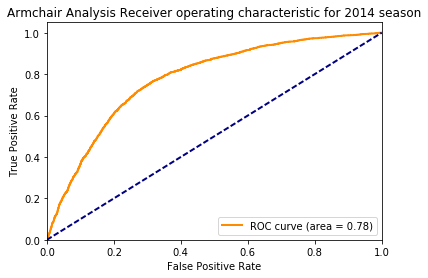

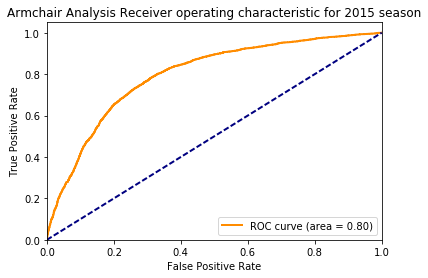

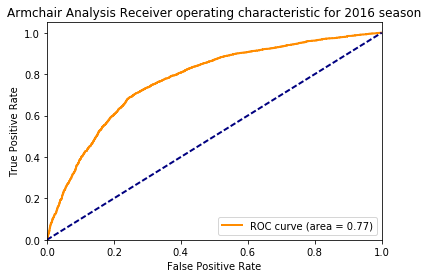

In [9]:
#generates ROC curve for each season
for roc_curve_rate in roc_curve_rates:
    #extract metrics from list
    year, fpr, tpr, auc = roc_curve_rate
    plt.figure()
    title = 'Armchair Analysis Receiver operating characteristic for ' + str(year) + ' season'
    lw = 2
    plt.plot(fpr, tpr, color = 'darkorange',
             lw = lw, label = 'ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()